<a href="https://colab.research.google.com/github/d-yacenko/ADCM_on_yandex/blob/main/network1_1_tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тематическая классификация длинных текстов - TFIDF и LogReg

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 289, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 289 (delta 10), reused 14 (delta 6), pack-reused 266
Receiving objects: 100% (289/289), 42.27 MiB | 20.19 MiB/s, done.
Resolving deltas: 100% (139/139), done.
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 1.7 MB 10.3 MB/s 
     |████████████████████████████████| 24.2 MB 1.5 MB/s 
     |████████████████████████████████| 304 kB 60.0 MB/s 
     |████████████████████████████████| 6.0 MB 72.3 MB/s 
     |████████████████████████████████| 10.1 MB 77.3 MB/s 
     |████████████████████████████████| 451 kB 41.3 MB/s 
     |████████████████████████████████| 181 kB 79.0 MB/s 
     |████████████████████████████████| 42 kB 2.0 MB/s 
     |████████████████████████████████| 628 kB 71.9 MB/s 
     |████████████████████████████████| 8.2 MB 31.6 MB/s 
  Created wheel for ufal.

In [2]:
#!rm -rf ./stepik-dl-nlp

In [3]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Предобработка текстов и подготовка признаков

In [4]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [5]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [6]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


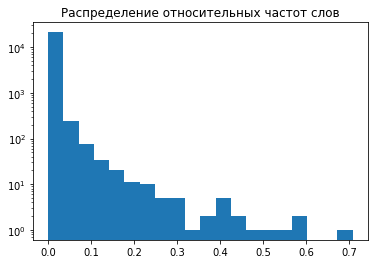

In [7]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [8]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


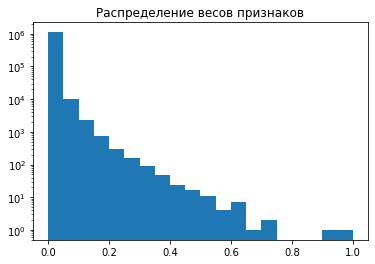

In [9]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [10]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


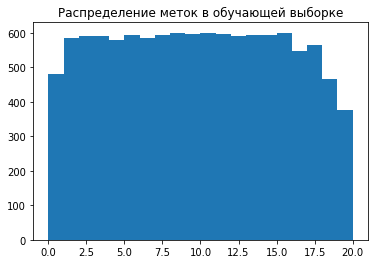

In [11]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

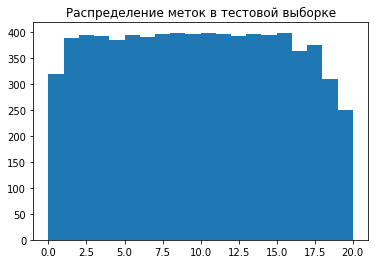

In [12]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [13]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [14]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 1.84 сек
Среднее значение функции потерь на обучении 2.2252577092014465
Среднее значение функции потерь на валидации 2.1137005080611018
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 1.71 сек
Среднее значение функции потерь на обучении 0.9165905559972182
Среднее значение функции потерь на валидации 1.6821941975819863
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 1.72 сек
Среднее значение функции потерь на обучении 0.4660171341929732
Среднее значение функции потерь на валидации 1.4643894560256248
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 1.72 сек
Среднее значение функции потерь на обучении 0.28363619441703214
Среднее значение функции потерь на валидации 1.3450368339732541
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 1.69 сек
Среднее значение функции потерь на обучении 0.19072452730546563
Среднее значение функции потерь на валидации 1.2602415398015814
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 1.76 сек
Среднее значение функции 

## Оценка качества

In [15]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:01<00:00, 222.46it/s]


Среднее значение функции потерь на обучении 0.0022322258446365595
Доля верных ответов 0.9994696835778681



236it [00:01, 224.54it/s]                             

Среднее значение функции потерь на валидации 0.9289411306381226
Доля верных ответов 0.76805629314923


In [16]:
!nvidia-smi


Sun Jan  9 19:05:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    35W / 250W |   1179MiB / 16280MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[7, 5, 0, 17, 19, 13, 15, 15, 5, 1, 2, 5, 17, 8, 0, 2, 4, 1, 6, 16, 1, 6, 17, 14, 3, 13, 11, 7, 7, 3, 5, 5, 4, 3, 14, 1, 9, 4, 6, 1, 17, 2, 8, 1, 11, 1, 14, 3, 11, 0, 8, 8, 13, 9, 1, 2, 10, 17, 16, 14, 8, 10, 17, 19, 2, 18, 18, 13, 0, 9, 8, 18, 10, 19, 3, 7, 18, 7, 18, 9, 6, 18, 17, 4, 12, 10, 16, 15, 8, 4, 14, 9, 16, 15, 16, 0, 9, 3, 3, 16, 2, 10, 14, 15, 3, 16, 10, 4, 14, 12, 8, 3, 17, 3, 8, 14, 9, 5, 9, 17, 12, 4, 4, 5, 9, 13, 18, 8, 3, 1, 16, 11, 6, 13, 10, 5, 5, 1, 3, 12, 10, 14, 7, 7, 10, 5, 10, 12, 0, 13, 14, 4, 15, 4, 6, 14, 18, 2, 10, 4, 11, 17, 9, 5, 3, 8, 2, 16, 6, 7, 1, 7, 7, 8, 4, 12, 10, 0, 10, 18, 4, 9, 5, 0, 3, 16, 8, 4, 0, 12, 18, 11, 13, 18, 3, 15, 16, 13, 3, 19, 15, 7, 4, 6, 15, 12, 9, 1, 16, 15, 2, 14, 14, 0, 16, 2, 1, 10, 2, 0, 7, 16, 12, 2, 14, 2, 7, 2, 5, 7, 17, 2, 4, 17, 15, 4, 15, 9, 0, 7, 3, 7, 8, 10, 14, 12, 14, 12, 11, 8, 15, 6, 4, 11, 6, 17, 7, 8, 10, 11, 4, 1, 5, 8, 1, 12, 18, 2, 13, 12, 8, 16, 18, 8, 4, 15, 5, 3, 11, 3, 15, 10, 3, 2, 14, 13, 17, 19, 6, 18

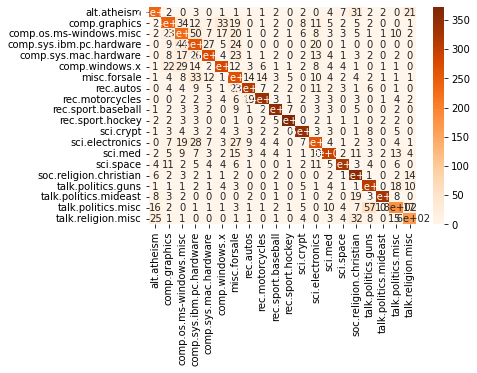

In [36]:
from sklearn import metrics
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names =  train_source.target_names
true_labels=[]
pred_labels=[]
# model_ft.eval()
for inputs,labels in test_dataset:
  pred = model.forward(inputs.to(device))
  pred = torch.argmax(pred)
  labels.to(torch.device("cpu"))
  pred.to(torch.device("cpu"))
  true_labels.append(int(labels));
  pred_labels.append(int(pred));
print(true_labels)
print(pred_labels)
cm=metrics.confusion_matrix(true_labels,pred_labels)
print(cm)
from pandas import DataFrame
import seaborn as sn
df_cm = DataFrame(cm, index=class_names, columns=class_names)
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)